#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Загрузим библиотеки и данные

In [1]:
import time
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error as mse

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим индекс на монотонность и осмотрим данные

In [3]:
print('Индекс монотонный?:', df.index.is_monotonic)
display(df.info(), df.head(), df.describe())

Индекс монотонный?: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Ресемплируем данные по одному часу

In [4]:
df = df.resample('1H').sum()

## Анализ

Осмотрим данные визуально

D:\WORK\anaconda\envs\praktikum_new\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


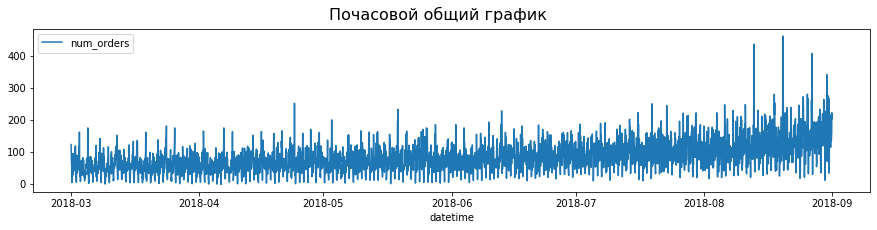

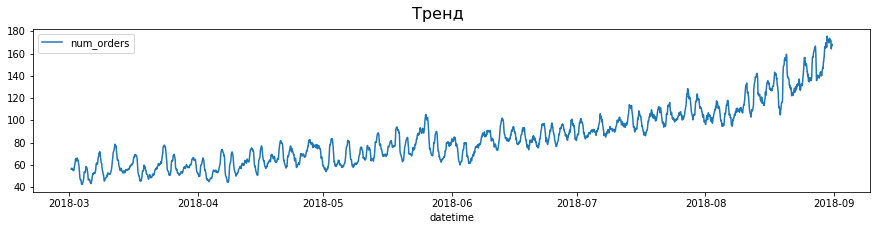

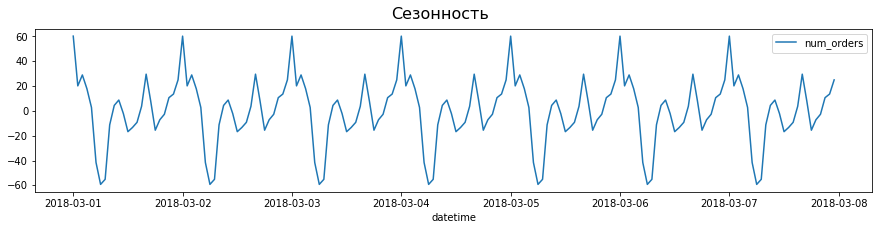

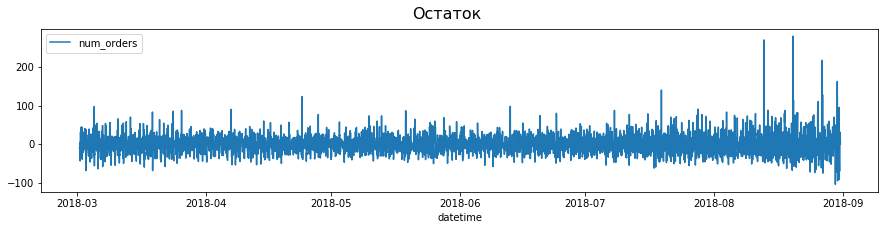

In [5]:
decomp = seasonal_decompose(df)

def decomp_plot(df, title=None):
    fig = plt.figure(figsize=(15, 3))
    sns.lineplot(data=df)
    fig.suptitle(title, fontsize=16)
    plt.show()
    
    return None

decomp_plot(df, title='Почасовой общий график')
decomp_plot(decomp.trend, 'Тренд')
decomp_plot(decomp.seasonal.head(168), 'Сезонность')
decomp_plot(decomp.resid, 'Остаток')

На визуализации мы видим растущий тренд заказов в течении выбранного периода, но нельзя утверждать об общем росте т.к. в масштабе нескольких лет это может быть сезонным явлением.

Так же мы видим сезонность в течении недели, с пиками в районе полуночи

## Обучение

Напишем трансформатор

In [6]:
class FeaturesMaker(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag, rolling_mean_size, y):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.y = y
        
    def _reset(self):        
        if hasattr(self, 'X_'):               
            del self.X_
            del self.y_
        
    def fit(self, X, y=None):
        self._reset()           
        self.X_ = X.drop(columns=self.y)
        self.y_ = X[self.y]
        
        return self
            
    def transform(self, X):

        temp = X.copy()
        
        for lag in range(self.max_lag):
            temp['lag_' + str(lag)] = temp[self.y].shift(lag+1)
            
        temp['rolling_mean'] = (temp[self.y]
                                .shift()
                                .rolling(self.rolling_mean_size)
                                .mean()
                               )
        
        temp['month'] = X.index.month
        temp['day'] = X.index.day
        temp['dayofweek'] = X.index.dayofweek
        temp['hour'] = X.index.hour
        for lag in  range(self.max_lag+1):
            temp.iloc[:lag+1, lag] = self.y_[-lag-1:].values.T
                
        temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \
        self.y_[-self.rolling_mean_size:].values.T
        
        temp = temp.drop(columns=self.y)

        return temp

Проверим работу

In [7]:
maker = FeaturesMaker(max_lag=4, rolling_mean_size=1, y='num_orders')
maker.fit_transform(df)

,lag_0,lag_1,lag_2,lag_3,rolling_mean,month,day,dayofweek,hour
datetime,,,,,,,,,
2018-03-01 00:00:00,223.0,159.0,154.0,136.0,205.0,3,1,3,0
2018-03-01 01:00:00,205.0,223.0,159.0,154.0,124.0,3,1,3,1
2018-03-01 02:00:00,85.0,205.0,223.0,159.0,85.0,3,1,3,2
2018-03-01 03:00:00,71.0,85.0,205.0,223.0,71.0,3,1,3,3
2018-03-01 04:00:00,66.0,71.0,85.0,205.0,66.0,3,1,3,4
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,207.0,217.0,197.0,116.0,207.0,8,31,4,19
2018-08-31 20:00:00,136.0,207.0,217.0,197.0,136.0,8,31,4,20
2018-08-31 21:00:00,154.0,136.0,207.0,217.0,154.0,8,31,4,21


Разделим данные на трейн и тест

In [8]:
X = df
y = df['num_orders']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                      test_size=.1, \
                                                      shuffle=False)

print(f'Целая выборка: {X.shape}\nОбучающая: {X_train.shape, y_train.shape}\nТестовая: {X_test.shape, y_test.shape}')

Целая выборка: (4416, 1)
Обучающая: ((3974, 1), (3974,))
Тестовая: ((442, 1), (442,))


Напишем скорер

In [10]:
def rmse(y, predictions):
    return np.sqrt(mse(y, predictions))

rmse_score = make_scorer(rmse, greater_is_better=False)

Обучим модели по сетке

In [11]:
cv = TimeSeriesSplit(n_splits=3)

pipe = Pipeline([
    ('maker', FeaturesMaker(max_lag=4, rolling_mean_size=1, y='num_orders')),
    ('model', LinearRegression())
])

params = [
    {
        'maker__max_lag': [24, 168],
        'maker__rolling_mean_size': [5, 10],
        'model': [LinearRegression()],
    }, {
        'maker__max_lag': [24, 168],
        'maker__rolling_mean_size': [5, 10],
        'model': [CatBoostRegressor(loss_function='RMSE', silent=True, random_state=42)],
        'model__n_estimators': [60, 150],
        'model__learning_rate': [0.1],
        'model__depth': [3, 5],
    }, {
        'maker__max_lag': [24, 168],
        'maker__rolling_mean_size': [5, 10],
        'model': [RandomForestRegressor(random_state=42)],
        'model__criterion': ['mse'],
        'model__max_depth': [3, 6, 9],
        'model__n_estimators': [100, 150],
    }, {
        'maker__max_lag': [24, 168],
        'maker__rolling_mean_size': [5, 10],
        'model': [LGBMRegressor(boosting_type='gbdt', random_state=42)],
        'model__n_estimators': [100, 150],
        'model__num_leaves': [21, 31, 41],
    }
]

grid = GridSearchCV(estimator=pipe, param_grid=params, \
                    scoring=rmse_score, cv=cv, n_jobs=-1)

In [12]:
%%time
grid.fit(X_train, y_train)

Wall time: 3min 44s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('maker',
                                        FeaturesMaker(max_lag=4,
                                                      rolling_mean_size=1,
                                                      y='num_orders')),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'maker__m...
                                                  n_estimators=100, n_jobs=-1,
                                     

In [13]:
display(grid.best_estimator_, grid.best_score_)

Pipeline(memory=None,
         steps=[('maker',
                 FeaturesMaker(max_lag=168, rolling_mean_size=10,
                               y='num_orders')),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000001F8D3B45608>)],
         verbose=False)

-24.348097542298046

Лучшей моделью оказался CatBoostRegressor, его и заберем в финал

## Тестирование

In [14]:
model = grid.best_estimator_

model.fit(X_train, y_train)
rmse(model.predict(X_test), y_test)

39.90561582187481

Визуализируем данные

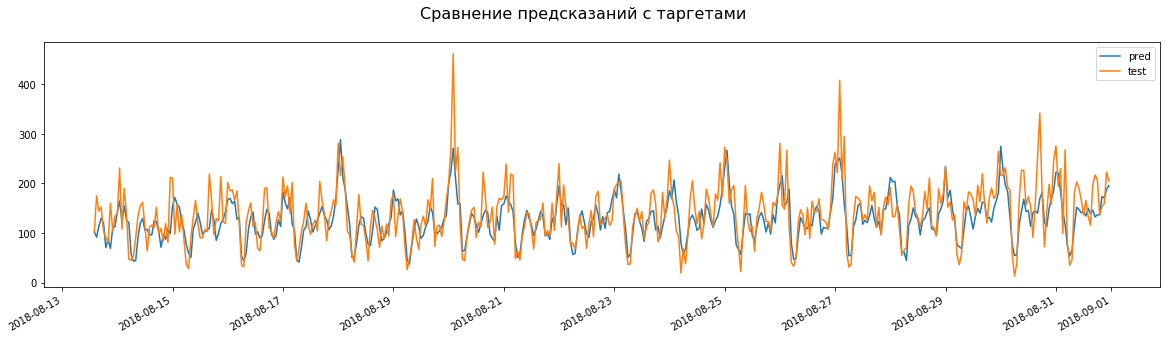

In [15]:
pred = pd.Series(model.predict(X_test), index=y_test.index)
fig = plt.figure(figsize=(20, 5))
sns.lineplot(data=pred, label='pred')
sns.lineplot(data=y_test, label='test')
fig.suptitle('Сравнение предсказаний с таргетами', fontsize=16)
fig.autofmt_xdate()
plt.show()

На графике видно, что в периоды сильных скачков спроса ошибка возрастает, но в остальное время модель достаточно точно угадывает величину спроса.

## Вывод

Целью исследования ставилось создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.

В ходе исследования было произведено ресемплирование данных по часу. В ходе анализа было выяснено, что данные за выбранный период имеют растущий тренд, но мы не можем точно сказать что это общий рост, так как в масштабе нескольких лет это может быть сезонным явлением. Так же данные имеют суточную сезонность с пиками в районе полуночи. Был подготовлен трансформатор, подобраны параметры и обучены модели.

Достигла целевой метрики и показала наилучший результат модель CatBoostRegressor, с ошибкой в 39 заказов.